# pH and Dying
Meagan Rittmanic & Dieter Brehm - Project 1 - Fall 2018  
A project examining how to model an assumed relation between crustaceans and pH levels

In [37]:
# Configure Jupyter so figures appear in the noebook
%matplotlib inline

# import functions from the modsim.py module
from modsim import *
import random
import matplotlib.pyplot as plt

### Question: If the pH in a certain ecosystem changes more than it usually does, what is the chance that a population of some species will go extinct?

PH changes, or the change in how acidic or basic a certain solution is, affect many different aspects of organism growth, including the pH levels in their blood and birthrate.

Many ecosystems such as coral reefs, oceans, and lakes have experienced the effects of changing pH levels, which can be due to an increase in carbon dioxide in the atmosphere or other causes.

In our simulation, we chose to look at how pH affected the birth rate of a certain population of small crustaceans, daphnia geleata. We had data points for the number of crustaceans born in each (approximately week-long) birth cycle, and extrapolated that data to see whether the population would go extinct during the time of our simulation.

We started by inputing the data we found online, from a journal article titled "Decrease in Daphnia Egg Viability at Elevated pH," from Limnology and Oceanography, Vol. 41, No. 4 (Jun., 1996), pp. 789-794 (6 pages), and fitting a line to that data.

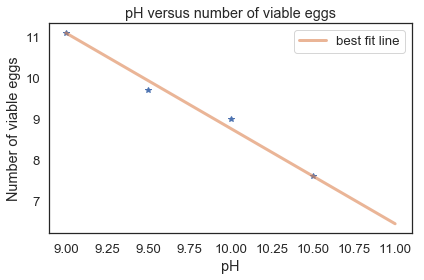

In [38]:
# Plot our data points for pH levels and crustacean birth rates 
plt.plot([9,9.5,10,10.5], [11.1, 9.7, 9, 7.6], '*')

# Create a best-fit line
def run_match():
    match = TimeSeries()
    match[9] = 11.1
    for p in linrange(9, 11, 1):
        match [p+1] = match[p] - 2.33
    return match

# overlay the fit line with our data
p2 = run_match()
plot(p2, label="best fit line")
decorate(xlabel = 'pH',
         ylabel = 'Number of viable eggs',
         title = 'pH versus number of viable eggs')
plt.show()

We can use our line of best fit to extrapolate our data.

In [39]:

def run_match2():
    match = TimeSeries()
    match[9] = 11.1
    for p in linrange(9, 11, 1):
        match [p+1] = match[p] - 2.33
    return match[11]
run_match2()

6.4399999999999995

We can then use that data to see how the normal birth rate was affected.
In this case, we assumed the normal birth rate to arbitrarily be 0.12 and the normal death rate to arbitrarily be 0.1. The average birth rate, birth, was determined by multiplying our normal birth rate by the ratio of the number of births extrapolated at a pH of 11 by the normal number of births, found from the data at a pH of 9.

We created a system object to store our parameters, with the birth rate being variable from year to year by an arbitrary plus or minus 0.07.

The initial population was assumed to be 40.

In [40]:
def reset_system():
    # set our constants
    birth_rate_normal = 0.12
    birth = run_match2()
    birth1 = birth_rate_normal*(birth/11.1)
    values = System(death=0.1, birth_lb = birth1-0.07, birth_ub = birth1+0.07, pop_0 = 40, time_period = 52)
 
reset_system()

We can then define a simulation function to run our results, with the birth rate being randomly generated every year within our given range.

We also defined a plot function to plot our results for one run of the simulation.

In [41]:
def run_ph_sim(system):
    """
    Runs the simulation

    system: a System object with our initial constants, relies on:
            - pop_0: initial population
            - birthi: lower range deviation of birthrate due to pH
            - birthii: upper range deviation of birthrate due to pH
            - death: death rate
            - time period: how many weeks to run the simulation for

    Return TimeSeries with results
    """
    run = TimeSeries()
    run[0] = system.pop_0
    for t in linrange (0, values.time_period, 1):
        for x in range(1):
            b = random.uniform(system.birth_lb, system.birth_ub)
        run[t+1] = run[t] + run[t]*(b)-run[t]*(system.death)
    return run

def plot_rps(variable, title):
    """
    Plots data

    variable: the data we want to graph 
    title: the title of the graph

    directly plots data with no return statement
    """
    plot (variable, label = 'crustacean population')
    decorate(xlabel = 'time (weeks)',
            ylabel = 'population of crustaceans',
            title = title)

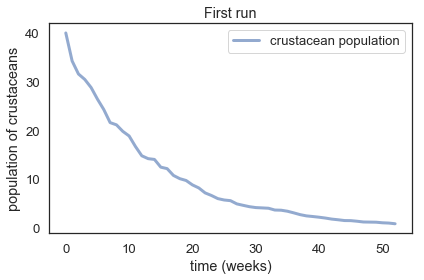

In [42]:
x = run_ph_sim(values)
plot_rps(x, 'First run')

In order to experiment with these ranges, let's see what happens when we sweep through a range of ranges from a very tight ph range to a larger one

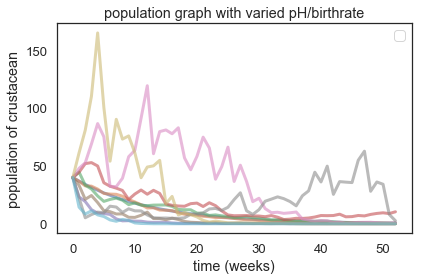

In [43]:
def birth_range_sweep(ub, lb, system):
    # sweep for a few different birthrate / pH ranges
    birth_ub_array = linspace(ub, lb, 10);

    for rate in birth_ub_array:
        # for now, let's keep the upper and lower limits absolute value the same
        values.birth_lb = birth1 - rate
        values.birth_ub = birth1 + rate
        x = run_ph_sim(values)
        plot(x)
    
    reset_system()
    
birth_range_sweep(0, 0.9, values)
    
decorate(xlabel = 'time (weeks)',
         ylabel = 'population of crustacean',
         title = "population graph with varied pH/birthrate")

We can make a slightly different simulation, this one returning only the final popluation from week 52, as opposed to a complete TimeSeries.

In [44]:
def run_ph_sim2(system):
    """
    Runs the simulation

    system: a System object with our initial constants, relies on:
            - pop_0: initial population
            - birthi: lower range deviation of birthrate due to pH
            - birthii: upper range deviation of birthrate due to pH
            - death: death rate
            - time period: how many weeks to run the simulation for 

    Return TimeSeries with 52nd result
    """

    run = TimeSeries()
    run[0] = system.pop_0
    
    for t in linrange (0, values.time_period, 1):
        for x in range(1):
            # randomly select a decimal number between
            # the lower and upper birth rate(pH) bounds
            b = random.uniform(system.birth_lb, system.birth_ub)
        run[t+1] = run[t] + run[t]*(b)-run[t]*(system.death)
        if run[t+1]<=8:
            extinct.extinct +=1
            return

We can create a new state object to store our number of simulations that return an extinct population.

We defined a new function that runs the simulation multiple times and records how many of those populations went extinct.
We assume that the minimum population that can still support survival is 9. Any population less than or equal to 8 is counted as extinct. We made this choice because the way we wrote our program, using proportional decay, would never actually allow our population to reach zero.

In [45]:
def run_program(number_of_runs, system, state):
    """
    Runs the simulation multiple times

    number_of_runs: how many times we want to run the simulation
    system: a System object with our initial constants, relies on:
            - extinct: tracks number of runs in which the population went extinct
    state: a State object with the number of extinctions that have occured
    
    """
    for i in range (number_of_runs):
        x = run_ph_sim2(system)
    return state.extinct

In [55]:
reset_system()

In [59]:
# run the simulation 100 times
extinct = State(extinct = 0)
extinctions = run_program(10, values, extinct)
print(extinct.extinct)

4


We can then project further to see what happens to the population 

11.1
10.80875
10.5175
10.22625
9.935
9.64375
9.352500000000001
9.061250000000001
8.770000000000001
8.478750000000002
8.187500000000002
7.896250000000002
7.605000000000002
7.313750000000002
7.022500000000003
6.731250000000003
6.440000000000003
6.148750000000003
5.8575000000000035
5.566250000000004
5.275000000000004
4.983750000000004
4.692500000000004
4.4012500000000045
4.110000000000005
3.818750000000005
3.527500000000005
3.2362500000000054
2.9450000000000056
2.653750000000006
2.362500000000006
2.0712500000000063


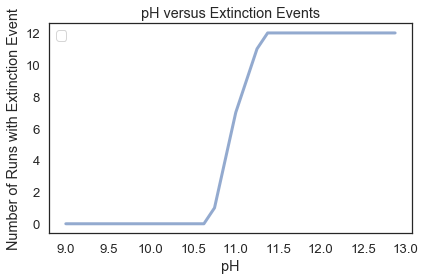

In [60]:
#step = 0.125

def run_match2_mult_it(projection):
    match = TimeSeries()
    match[9] = 11.1
    for p in linrange(9, projection, 0.125):
        match [p+0.125] = match[p] - 2.33 * (0.125)
    return match[projection]

crustydead = Series()

for proj in linrange(9, 13, 0.125):
    
    iterations=run_match2_mult_it(proj)
    print(iterations)
    
    birth_rate_normal = 0.12
    birth = run_match2_mult_it(proj)
    birth1 = birth_rate_normal*(birth/11.1)
    values = System(death=0.1, birth_lb = birth1-0.07, birth_ub = birth1+0.07, pop_0 = 40, time_period = 52)
    
    extinct = State(extinct = 0)
    extinctions = run_program(12, values, extinct)
    crustydead[proj] = extinct.extinct
    
plot (crustydead)
decorate(xlabel = 'pH',
         ylabel = 'Number of Runs with Extinction Event',
         title = 'pH versus Extinction Events')